# Artificial Neural Network fundamentals

- Neural Network is a supervised learning algorithm that takes input $X \in \mathbb{R}^D$ and passes it through hidden layers and finally produces an output through a function
- Most prominent task in Computer Vision is to classify an object in a particular image, i.e is the object an cat or dog given features $X \in \mathbb{R}^D$
- Imagenet was a competition held to identify the class an object belongs to in an image.  Initially, classification error was 28% in 2010.  In 2016, its reduced to 3.1%
- AlexNet is a neural network that was used in the winning solution for the ImageNet Competition in 2012 with 16.4% classificatioin error rate.  As more complex neural networks were created, this reduced the error even further to 3.1% beating human level accuracy.  

#  Traditional Machine Learning
- suppose you have a task to identify whether a picture contains a dog or not.  In traditional setting, ML practioner will identify the relevant features of the image and then extract those features and pass it through an classification algorithm that deciphers the given features to classify whether the image is a dog or not

- Say you had two images of a dog.  A simple rule might be, if there are 3 black circles in an image, this is a dog.  
- But this same rule will fail on an image of a cake that has black round spot in the middle and two triangular black spots above the middle black spot.  
- This rule will also fail if you showed any other image with similar features. 
- Hence, the number of rules needed to accurately classifiy this image can be exponential and images vary a lot, so this rule will not be applicable to other images of a dog. 
- ANN makes this simple.  
- Neural networks help with feature extraction and using those features for classification/regression.  There is little need of manual feature engineering.  
- __Feature Engineering__: Manual identification of features and extraction of the features
- Neural network only needs labelled training data and an architecture.  It does not need a human to come up with rules to classifiy an image.  
- For ANN, we need to provide lots of data (examples) such as images that are dogs and not dogs so that the model can learn the features.  

# Artificial Neural Network
- Also known as multilayer perceptrons or deep nets
- Supervised learning algorithm thats composed of a network of small computing units, each of which takes a vector of inputs $(x_1, x_2, ..., x_D)$ and produces a single output value
- Feed forward neural network: computation proceeds iteratively, from one layer of units to next
- Building block of neural network is a single computational unit
- Unit takes a set of real valued numbers, performs computation on them and produces an output
- More formally, given inputs $(x_1, x_2, ..., x_D)$, a unit takes these inputs and corresponding weights $(w_1, w_2, ..., w_D)$ and a bias and computes:

$z = w^Tx + b$ where

$x \in R^D, w \in R^D, z \in R, b \in R$

and performs a non linear transformation on the output: $y = f_{\theta}(z)$ where $f$ is called activation function

Above is an example of single layer neural network with a single unit

## Stacking neurons
- A more complex neural network may take a single neuron as described above, and stack them together, such that, neuron passes its output as input to next neuron resulting in more complex function
- __A two layer fully connected neural network__ with m hidden units and d dimensional input $x \in R^D$ is defined as:

for $j \in {1, 2, ..., m}$, 

$z_j = w^T_j x + b_j, wj \in R^D, b_j \in R$

$a_j = Relu(z_j)$

$(a_1, a_2, ..., a_m)^T \in R^m$

$f_{\theta}(x) = \theta^T a + \theta_c$

Writing this in terms of vectorized:

$z = W^{in}x + b$ where $W^{in} \in R^{mxd}$ and $b \in R^m$

$a = ReLu(z)$

$y = W^{out} a + b_{out}$ where $W^{out} \in R^m$ and $b_{out} \in R$

## Classifiying handwritten digits
- obtain the MNIST dataset that contains handwritten digits  from 250 people.  Goal is to classify each image in the digit to one of 10 possible, 0-9 classes

In [35]:
from __future__ import annotations
from sklearn.datasets import fetch_openml


X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values


In [2]:
X.shape

(70000, 784)

- nxd dimensional X matrix consists of 70k images, with 784 pixels each and y array stores corresponding 70k class labels
- images in the MNIST dataset consists of 28x28 pixels, each pixel representd by greyscale.  Hence, openml already unrolled the 28x28 pixels into one dimensional row vector which represents the X array, or 784 rows per image and y contains the target labels which are integers in 0-9 range of handwritten digits
- lets normalize the digits in -1 to 1 range.  division by 255 normalizes it in 0-1 range
- this will allow gradient descent to be more stable under these conditions
- after rescaling, lets plot hte images to see how it looks

In [36]:
X = ((X / 255.) - 0.5) * 2

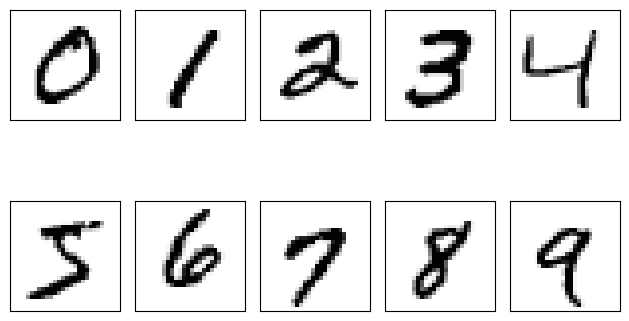

In [37]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X[y==i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

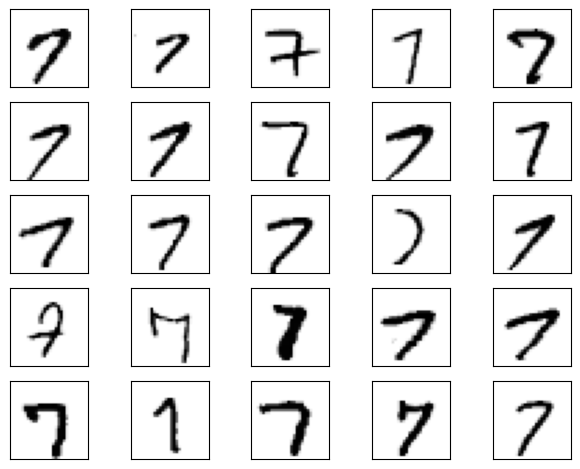

In [38]:
# plot of multiple examples of same digit to see how different the handwriting for each really is

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = X[y == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout();
plt.show();

- dividing the data in to training, validation and test sets.  
- use 55k for train, 5k for validation and 10k for testing

In [39]:
from sklearn.model_selection import train_test_split
X_dev, X_test, y_dev, y_test = train_test_split(
    X, y, test_size=10000, random_state=123, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_dev, y_dev, test_size=5000, random_state=123, stratify=y_dev)


## Implementing a MultiLayer Perceptron
- assume one hidden layer

In [40]:
y

array([5, 0, 4, ..., 4, 5, 6])

In [17]:
import numpy as np
def sigmoid(z):
    return 1./(1. + np.exp(-z))

def Relu(z):
    return np.where(z > 0, z, 0)

def int_to_onehot(y, num_labels):
    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1
    return ary

In [42]:
class NeuralNetMLP:
    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        self.num_classes = num_classes

        # hidden
        rng = np.random.RandomState(random_seed)
        self.weight_h = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features)
        )
        self.bias_h = np.zeros(num_hidden)

        # output
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_classes)
        )
        self.bias_out = np.zeros(num_classes)
    
    def forward(self, x):
        z_h = x @ self.weight_h.T + self.bias_h
        a_h = sigmoid(z_h)

        # output layer
        z_out = a_h @ self.weight_out + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_out
    
    def backward(self, x, a_h, a_out, y):
        # one hot encoding of class labels
        y_onehot = int_to_onehot(y, self.num_classes)

        # part 1: dloss/dWOut = dloss/dOutAct * dOutAct/dZOut * dZOut/dWOut
        dloss_dAOut = 2*(a_out - y_onehot) / y.shape[0]
        dAOut_dZout = a_out * (1 - a_out)
        dZOut_dWOut = a_h

        deltaOut = dloss_dAOut * dAOut_dZout

        dlossdWOut = deltaOut.T @ dZOut_dWOut # (txn) (nxm) = txm matrix
        dlossdbOut = np.sum(deltaOut, axis=0)

        # part 2: dloss/dHiddenWeights
        dZOut_dAH = self.weight_out
        dAH_dZH = a_h * (1 - a_h)
        dZH_dWH = x

        dloss_dAh = np.dot(deltaOut, dZOut_dAH.T)
        dloss_dWh = np.dot((dloss_dAh * dAH_dZH).T, dZH_dWH)
        dloss_dbh = np.sum((dloss_dAh * dAH_dZH), axis=0)

        return (dlossdWOut, dlossdbOut, dloss_dWh, dloss_dbh)

In [43]:
model = NeuralNetMLP(num_features=28*28, num_classes=10, num_hidden=50)

In [44]:
# now to train the model.
# create a minibatch generator that takes our dataset and divides it into minibatches of desired size for stochastic gradient descent training

def mini_batch_generator(X, y, batch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    for start_idx in range(0, indices.shape[0] - batch_size + 1, batch_size):
        batch_idx = indices[start_idx: start_idx + batch_size]
        yield X[batch_idx], y[batch_idx]

In [19]:
for X_train_mini, y_train_mini in mini_batch_generator(X_train, y_train, 100):
    break


In [20]:
X_train_mini.shape

(100, 784)

In [21]:
y_train_mini.shape

(100,)

In [30]:
import pandas as pd
def mse_loss(targets, probabs, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probabs)**2)

def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets)

In [26]:
_, probabs = model.forward(X_val)
mse = mse_loss(y_val, probabs)
mse

0.24694322840508198

In [27]:
predicted_labels = np.argmax(probabs, axis=1)

In [28]:
predicted_labels

array([5, 5, 5, ..., 8, 5, 5])

In [31]:
acc = accuracy(y_val, predicted_labels=predicted_labels)
print(f"initial accuracy {acc * 100:.2f}")

initial accuracy 10.62


In [32]:
def compute_mse_and_acc(nnet, X, y, num_labels=10,batch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    for B, (features, targets) in enumerate(mini_batch_generator(X, y, batch_size)):
        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)
        
        loss = mse_loss(targets, probas, num_labels)
        correct_pred += (predicted_labels == targets).sum()
        num_examples += targets.shape[0]
        mse += loss
    mse = mse / B
    acc = correct_pred / num_examples
    return mse, acc

In [33]:
mse, acc = compute_mse_and_acc(model, X_val, y_val)

In [34]:
mse, acc

(0.25198288612763464, 0.1062)

In [50]:
def train(model: NeuralNetMLP, X_train, y_train, X_val, y_val, num_epochs, learning_rate=0.1):
    epoch_loss = []
    epoch_train_acc = []
    epoch_val_acc = []

    for e in range(num_epochs):
        # iterate over minibatches
        for X_train_mini, y_train_mini in mini_batch_generator(
            X_train, y_train, batch_size=100
        ):
            # compute the outputs
            a_h, a_out = model.forward(X_train_mini)

            # compute gradients
            dloss_dwout, dloss_dbout,\
            dloss_dwh, dloss_dbh = \
            model.backward(X_train_mini, a_h, a_out, y_train_mini)

            # update the weights
            model.weight_h -= learning_rate * dloss_dwh
            model.bias_h -= learning_rate * dloss_dbh
            model.weight_out -= learning_rate * dloss_dwout.T
            model.bias_out -= learning_rate * dloss_dbout
        
        train_mse, train_acc = compute_mse_and_acc(
            model, X_train, y_train
        )
        val_mse, val_acc = compute_mse_and_acc(
            model, X_val, y_val
        )
        train_acc, val_acc = train_acc * 100, val_acc * 100
        epoch_train_acc.append(train_acc)
        epoch_val_acc.append(val_acc)
        epoch_loss.append(train_mse)
        print(f'Epcoh: {e+1:03d}/{num_epochs:03d}'
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Val acc: {val_acc:.2f}%')
    
    return epoch_loss, epoch_train_acc, epoch_val_acc

In [51]:
# training for 50 epochs
np.random.seed(123)
epoch_loss, epoch_train_acc, epoch_valid_acc = train(
    model, X_train, y_train, X_val, y_val,
    num_epochs=50, learning_rate=0.1
)

Epcoh: 001/050| Train MSE: 0.05 | Train Acc: 74.92% | Val acc: 74.04%
Epcoh: 002/050| Train MSE: 0.03 | Train Acc: 85.55% | Val acc: 85.38%
Epcoh: 003/050| Train MSE: 0.02 | Train Acc: 87.99% | Val acc: 87.78%
Epcoh: 004/050| Train MSE: 0.02 | Train Acc: 89.37% | Val acc: 89.18%
Epcoh: 005/050| Train MSE: 0.02 | Train Acc: 90.15% | Val acc: 90.22%
Epcoh: 006/050| Train MSE: 0.02 | Train Acc: 90.62% | Val acc: 90.66%
Epcoh: 007/050| Train MSE: 0.02 | Train Acc: 91.09% | Val acc: 91.00%
Epcoh: 008/050| Train MSE: 0.02 | Train Acc: 91.36% | Val acc: 91.30%
Epcoh: 009/050| Train MSE: 0.01 | Train Acc: 91.76% | Val acc: 91.72%
Epcoh: 010/050| Train MSE: 0.01 | Train Acc: 92.01% | Val acc: 91.84%
Epcoh: 011/050| Train MSE: 0.01 | Train Acc: 92.30% | Val acc: 92.06%
Epcoh: 012/050| Train MSE: 0.01 | Train Acc: 92.49% | Val acc: 92.20%
Epcoh: 013/050| Train MSE: 0.01 | Train Acc: 92.67% | Val acc: 92.38%
Epcoh: 014/050| Train MSE: 0.01 | Train Acc: 92.90% | Val acc: 92.64%
Epcoh: 015/050| Trai

### Intuition building
- In feed forward propagation, we connect the input layer to the hidden layer by computing the linear combination of weights and inputs and then from hidden layer to output layer by computing the linear combination of weights and activation values, make a prediction and finally compute the loss as a result of propagating information through the network
- In back propagation, its the reverse, we start with the loss value from feed forward propagation and then move backwards to the newtwork to find the set of weights that makes the loss as small as possible
- loss value is reduced in following steps: 
  - change the weight by a small amount $\delta w$
  - calculate the change in loss $\delta L$ due to change in $\delta w$
  - update the weight in by taking a step in the direction opposite of the gradient;
        
  $w_j^{t+1} \leftarrow w_j^{t} - k\frac{\delta L}{\delta w}$

  - update made to weight is proportional to amount of loss thats reduced by changing the weight by a small amount
  - if preceding steps is done n amount of time over entire training set, we are training then for __n epochs__
  - when training for n epochs, we are using the entire dataset.  In practice, we usually have thousands or millions of data points, hence calculating the loss by taking the entire training set is computationally intensive and there is diminishing returns in having large dataset to calculate the loss.  So use a batch size.  For each pass in training set, calculate loss on each batch until we exchaust all the training data points.  Batch size is usually 30, 100 or 1024
  - Assume 3 hidden units for hidden layer
  - Assume output layer has one unit
  - Assume single data point with two features initialized to 1, 1
  - Hence we have 3x2 = 6 weights for hidden layer, plus 3 bias units for a total of 9 weights that connects inputs to hidden layer
  - we also have 3 weights from hidden to output layer and one bias.  Hence alltogether, we have 13 parameters we need to estimate
  - Assume continuous output and input

In [71]:
from copy import deepcopy
import numpy as np
x = np.array([[1, 1]])
y = np.array([[0]])
rng = np.random.RandomState(123)
weight_h = np.array([[-0.0053, 0.3793],
                     [-0.5820, -0.5204],
                     [-0.2723, .1896]], dtype=np.float32)
bias_h = np.array([-0.0140, 0.5607, -0.0628], dtype=np.float32)
weight_o = np.array([[0.1528, -0.1745, -0.1135]], dtype=np.float32)
bias_o = np.array([-0.5516], dtype=np.float32)
W = [weight_h, bias_h, weight_o, bias_o]


In [72]:
def feed_fwd(inputs, outputs, weights):
    z = np.dot(inputs,weights[0].T) + weights[1]
    a = sigmoid(z)
    pred = np.dot(a, weights[2].T) + weights[3]
    loss = np.mean((pred - outputs)**2)
    return loss

def update_weights(inputs, outputs, weights, lr):
    updated_weights = deepcopy(weights)
    original_loss = feed_fwd(inputs, outputs, weights)

    for i, layer in enumerate(weights):
        for index, _ in np.ndenumerate(layer):
            temp_weights = deepcopy(weights)
            temp_weights[i][index] += 0.0001
            new_loss = feed_fwd(inputs, outputs, temp_weights)
            grad = (new_loss - original_loss) / 0.0001
            updated_weights[i][index] -= lr*grad
    return updated_weights, original_loss
    



In [73]:
losses = []
for epoch in range(100):
    W, loss = update_weights(x, y, W, 0.01)
    losses.append(loss)

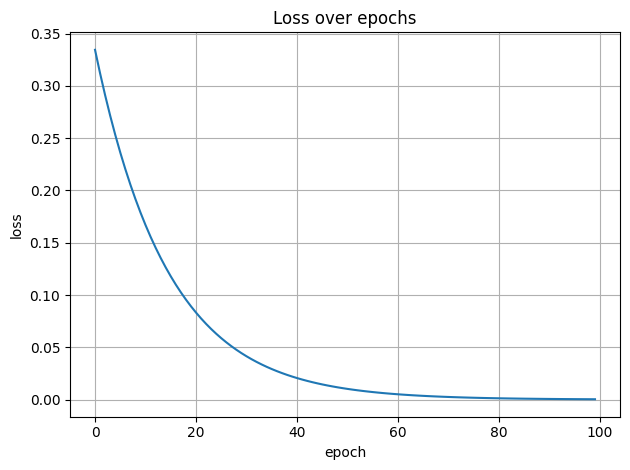

In [75]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.title("Loss over epochs")
plt.xlabel("epoch");
plt.ylabel("loss");
plt.grid();
plt.tight_layout()

In [77]:
W

[array([[ 0.01424004,  0.39883757],
        [-0.5907864 , -0.52918637],
        [-0.27549535,  0.18640439]], dtype=float32),
 array([ 0.00554004,  0.5519136 , -0.06599568], dtype=float32),
 array([[ 0.3475135 , -0.05529078,  0.03760847]], dtype=float32),
 array([-0.22443289], dtype=float32)]

#### Now predict hte output given the updated weight

In [78]:
z = np.dot(x, W[0].T) + W[1]
a = sigmoid(z)
pred = np.dot(a, W[2].T) + W[3]
pred # very close to 0

array([[-0.0174781]])

## Understanding the impact of learning rate
- Suppose we want to estimate the weight in the following equation: $y = 3 * x$
- Assume $y = wx + b$

In [89]:
x = np.array([1, 2, 3, 4]).reshape(4, 1)
y = np.array([[3, 6, 9, 12]]).reshape(4, 1)



In [90]:
# assume no hidden layer
def custom_feed_fwd(inputs, outputs, weights):
    pred = np.dot(inputs, weights[0]) + weights[1]
    loss = np.mean((pred - outputs) ** 2)
    return loss

In [91]:
def custom_update_weights(inputs, outputs, weights, lr):
    original_loss = custom_feed_fwd(inputs, outputs, weights)
    updated_weights = deepcopy(weights)

    for i, layer, in enumerate(weights):
        for index, weight in np.ndenumerate(layer):
            temp_weights = deepcopy(weights)
            temp_weights[i][index] += 0.0001
            new_loss = custom_feed_fwd(inputs, outputs, temp_weights)
            grad = (new_loss - original_loss) / 0.0001
            updated_weights[i][index] -= grad * lr
    return updated_weights

In [114]:
# initialize weights and bias
W = [np.array([[0]], dtype=np.float32),
   np.array([[0]], dtype=np.float32)]

In [118]:
weight_value = []
def run(lr, W, weight_value):
    weight = deepcopy(W)
    for epx in range(1000):
        weight = custom_update_weights(x, y, weight, lr)
        weight_value.append(weight[0][0][0])

In [119]:
run(0.01, W, weight_value)

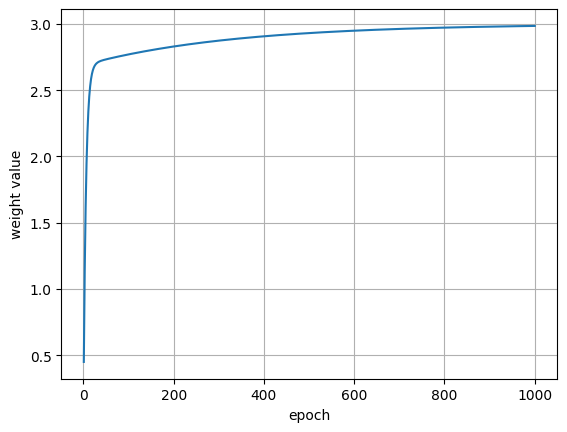

In [120]:
plt.plot(range(1, 1001), weight_value)
plt.grid()
plt.xlabel("epoch");
plt.ylabel("weight value");

### Note
- note that the weight value actually gradually increased over increasing epochs and eventually converges to 3

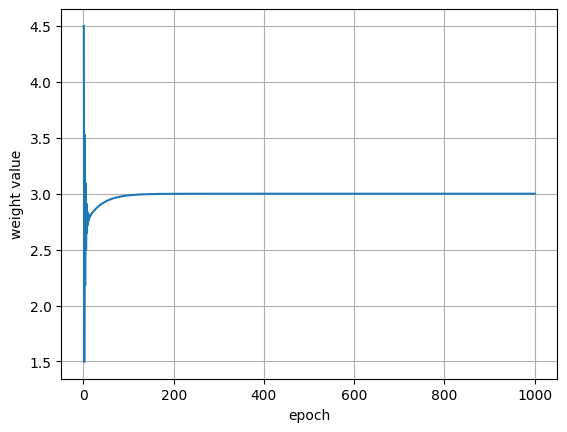

In [121]:
weight_value = []
run(0.1, W, weight_value)
plt.plot(range(1, 1001), weight_value)
plt.grid()
plt.xlabel("epoch");
plt.ylabel("weight value");

## Note
- when the learning rate was small (0.01), weight value moved slowly over increasing epochs towards optimal value. 
- but with a slightly higher learning rate, 0.1, it oscillates initially and then eventually converges to true value much quicker
- Finally, the graph below shows that when learning rate is 1, very high, weight value will spike to a high value and not be able to find the optimal weight:

run()

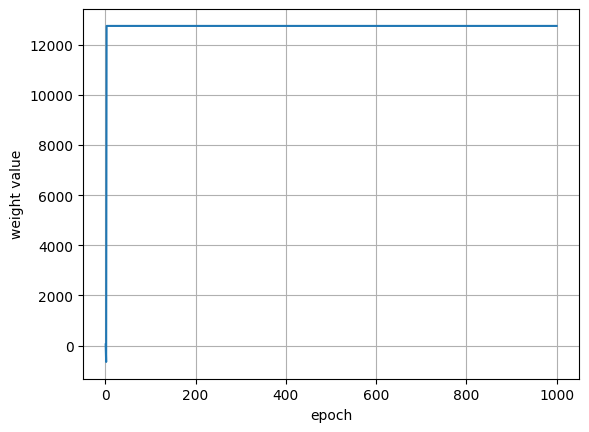

In [122]:
weight_value = []
run(1, W, weight_value)
plt.plot(range(1, 1001), weight_value)
plt.grid()
plt.xlabel("epoch");
plt.ylabel("weight value");

## Note
- the reason the weight value did not spike by a large amount when learning rate was low is that we restricted the weight update by a small amoount that was equal to gradient * learning_rate, resulting in a small amount of weight update when the learning rate is small.  
- But when learning rate is high, weight update is high, after which change in loss is so small(due to small change in weight) that the weight could not achieve its optimal value.  
- in order to get a deeper understanding of the relationship between learning rate, gradient, and weight value, lets update the weight function and observe the following

In [148]:
def custom_update_weights(inputs, outputs, weights, lr):
    original_loss = custom_feed_fwd(inputs, outputs, weights)
    updated_weights = deepcopy(weights)

    for i, layer, in enumerate(weights):
        for index, weight in np.ndenumerate(layer):
            temp_weights = deepcopy(weights)
            temp_weights[i][index] += 0.0001
            new_loss = custom_feed_fwd(inputs, outputs, temp_weights)
            grad = (new_loss - original_loss) / 0.0001
            updated_weights[i][index] -= grad * lr
            # just print out the slope, not the intercept 
            if i == 0:
                print("Weight Value: ", \
                      np.round(weights[i][index], 4), \
                        'original loss: ', np.round(original_loss, 4), \
                        'new loss: ', np.round(new_loss, 4), \
                            'gradient: ', np.round(grad, 4), \
                                'updated weights: ', \
                                    np.round(updated_weights[i][index], 4))

    return updated_weights

In [149]:
weight_value = []
def run(lr, W, weight_value, epoch=10):
    weight = deepcopy(W)
    for epx in range(epoch):
        weight = custom_update_weights(x, y, weight, lr)
        weight_value.append(weight[0][0][0])

In [150]:
run(0.01, W, weight_value, epoch=10)

Weight Value:  0.0 original loss:  67.5 new loss:  67.4955 gradient:  -44.9992 updated weights:  0.45
Weight Value:  0.45 original loss:  46.879 new loss:  46.8753 gradient:  -37.4944 updated weights:  0.8249
Weight Value:  0.8249 original loss:  32.5718 new loss:  32.5687 gradient:  -31.2579 updated weights:  1.1375
Weight Value:  1.1375 original loss:  22.6413 new loss:  22.6387 gradient:  -26.0521 updated weights:  1.398
Weight Value:  1.398 original loss:  15.7508 new loss:  15.7486 gradient:  -21.7158 updated weights:  1.6152
Weight Value:  1.6152 original loss:  10.9696 new loss:  10.9678 gradient:  -18.1037 updated weights:  1.7962
Weight Value:  1.7962 original loss:  7.6519 new loss:  7.6504 gradient:  -15.0948 updated weights:  1.9472
Weight Value:  1.9472 original loss:  5.3497 new loss:  5.3484 gradient:  -12.5885 updated weights:  2.0731
Weight Value:  2.0731 original loss:  3.7521 new loss:  3.751 gradient:  -10.4882 updated weights:  2.1779
Weight Value:  2.1779 original

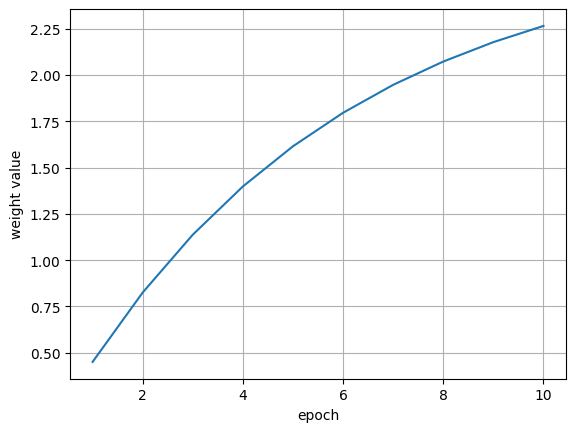

In [151]:
plt.plot(range(1, 11), weight_value)
plt.grid()
plt.xlabel("epoch");
plt.ylabel("weight value");

- Notice that the loss value is decrasing slowly when learning rate is 0.01 and weight is increasing slowly towards 3

Weight Value:  0.0 original loss:  67.5 new loss:  67.4955 gradient:  -44.9992 updated weights:  4.4999
Weight Value:  4.4999 original loss:  30.3726 new loss:  30.3756 gradient:  30.0403 updated weights:  1.4959
Weight Value:  1.4959 original loss:  13.7868 new loss:  13.7848 gradient:  -20.315 updated weights:  3.5274
Weight Value:  3.5274 original loss:  6.2541 new loss:  6.2554 gradient:  13.457 updated weights:  2.1817
Weight Value:  2.1817 original loss:  2.8537 new loss:  2.8528 gradient:  -9.136 updated weights:  3.0953
Weight Value:  3.0953 original loss:  1.3292 new loss:  1.3298 gradient:  5.9728 updated weights:  2.498
Weight Value:  2.498 original loss:  0.6454 new loss:  0.645 gradient:  -4.1242 updated weights:  2.9104
Weight Value:  2.9104 original loss:  0.3363 new loss:  0.3365 gradient:  2.6301 updated weights:  2.6474
Weight Value:  2.6474 original loss:  0.1956 new loss:  0.1954 gradient:  -1.8817 updated weights:  2.8356
Weight Value:  2.8356 original loss:  0.129

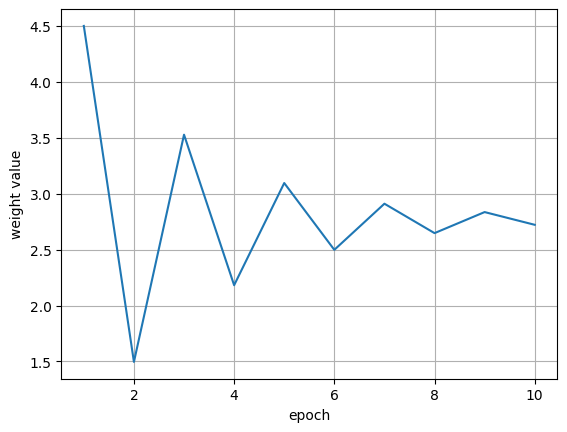

In [156]:
weight_value = []
run(0.1, W, weight_value, epoch=10)
plt.plot(range(1, 11), weight_value)
plt.grid()
plt.xlabel("epoch");
plt.ylabel("weight value");

- When the learning rate was 0.01, weight updated much slower than compared to a learning rate of 0.1 (from 0 to 0.45 in first epoch for learning rate of 0.01 and 0 to 4.5 when the learning rate is 0.1).  Reason for slower update is the lower learning rate as weight = gradient * learning rate
- gradient is negative when the weight value is smaller than the optimal value while positive when the weight value is larger than optimal value.  This phenomenon helps us update the weight values in the right direction


Weight Value:  0.0 original loss:  67.5 new loss:  67.4955 gradient:  -44.9992 updated weights:  44.9992
Weight Value:  44.9992 original loss:  16604.4462 new loss:  16604.5161 gradient:  699.2231 updated weights:  -654.2238
Weight Value:  -654.2238 original loss:  4030779.102 new loss:  4030777.761 gradient:  -13409.3837 updated weights:  12755.16
Weight Value:  12755.16 original loss:  1473935827.5885 new loss:  1473935827.5885 gradient:  0.0 updated weights:  12755.16
Weight Value:  12755.16 original loss:  1473935827.5885 new loss:  1473935827.5885 gradient:  0.0 updated weights:  12755.16
Weight Value:  12755.16 original loss:  1473935827.5885 new loss:  1473935827.5885 gradient:  0.0 updated weights:  12755.16
Weight Value:  12755.16 original loss:  1473935827.5885 new loss:  1473935827.5885 gradient:  0.0 updated weights:  12755.16
Weight Value:  12755.16 original loss:  1473935827.5885 new loss:  1473935827.5885 gradient:  0.0 updated weights:  12755.16
Weight Value:  12755.16 

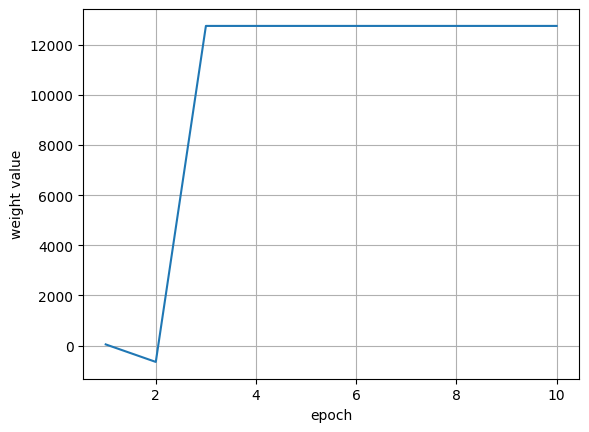

In [157]:
weight_value = []
run(1, W, weight_value, epoch=10)
plt.plot(range(1, 11), weight_value)
plt.grid()
plt.xlabel("epoch");
plt.ylabel("weight value");

- weight value has deviated to a very high value (in first epoch) which further deviated to a high value.  Since the weight value moved to a large amount, small changes in weight barelu affects the loss and hence gradient, hence weight got stuck at high value

### Summary of the training process of a neural network
- Training a neural network is aprocess of coming up with optimal weights by repeating two steps: forward propagation and back propagation with a given learning rate
- in forward prop, we apply a set of weights to the input data, pass it through the defined layers, perform non linear activation on hidden layers output and then connect the hidden layer to output layer by multiplying the hidden layer node values with another set of weights to estimate the output.  Then we finally calculate the overall loss corresponding to given set of weights.  For the first step, values of weights are initialized randomly
- in back prop, we decrease the loss by adjusting the weight by a small amount and, calculating the gradient and then updating hte weight in the direction opposite to the gradient.  Magnitude of weight update is gradient times learning rate
- process of feed forward and backward prop is repeated until we achieve a minimal loss as possible.  